<a href="https://colab.research.google.com/github/songqsh/foo1/blob/master/src/nn_learn_bsm_formula.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
import scipy.stats as ss

import torch
import torch.nn as nn
from torch.autograd import grad

In [0]:
'''=========
option class init
=========='''
class VanillaOption:
    def __init__(
        self,
        otype = 1, # 1: 'call'
                  # -1: 'put'
        strike = 110.,
        maturity = 1.,
        market_price = 10.):
      self.otype = otype
      self.strike = strike
      self.maturity = maturity
      self.market_price = market_price #this will be used for calibration
      
        
    def payoff(self, s): #s: excercise price
      otype = self.otype
      k = self.strike
      maturity = self.maturity
      return np.max([0, (s - k)*otype])

Next, we create the gbm class, which is 
determined by three parameters. We shall initialize it
as it  is created.

In [0]:
'''============
Gbm class inherited from sde_1d
============='''

class Gbm:
    def __init__(self,
                 init_state = 100.,
                 drift_ratio = .0475,
                 vol_ratio = .2
                ):
        self.init_state = init_state
        self.drift_ratio = drift_ratio
        self.vol_ratio = vol_ratio

BSM formula is given by a method of Gbm class with an input of an option.

In [0]:
'''========
Black-Scholes-Merton formula. 
=========='''

def bsm_price(self, vanilla_option):
    s0 = self.init_state
    sigma = self.vol_ratio
    r = self.drift_ratio
    
    otype = vanilla_option.otype
    k = vanilla_option.strike
    maturity = vanilla_option.maturity
    
    d1 = (np.log(s0 / k) + (r + 0.5 * sigma ** 2) 
          * maturity) / (sigma * np.sqrt(maturity))
    d2 = d1 - sigma * np.sqrt(maturity)
    
    return (otype * s0 * ss.norm.cdf(otype * d1) #line break needs parenthesis
            - otype * np.exp(-r * maturity) * k * ss.norm.cdf(otype * d2))

Gbm.bsm_price = bsm_price

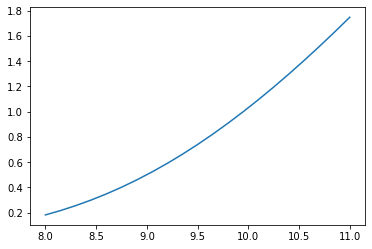

In [5]:
'''===========
target function
==========='''

def f(s):
  gbm = Gbm(init_state=s)
  option = VanillaOption(strike=10)
  return gbm.bsm_price(option)

batch_size = 21
x_list = np.linspace(8, 11, batch_size)
y_list = np.array([f(x) for x in x_list])
plt.plot(x_list, y_list)

In [0]:
H1 = 50; H2 = 11 #number of hidden layer
model = nn.Sequential(
    nn.Linear(1, H1), 
    nn.Sigmoid(),
    nn.Linear(H1, H2),
    nn.Sigmoid(),
    nn.Linear(H2,2),
    nn.Sigmoid(),
    nn.Linear(2,1)
    
)
#loss function 
criterion = nn.MSELoss()
#optimizer
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.7)


In [0]:
batch_size = np.size(x_list)
x_train0 = torch.from_numpy(x_list).reshape(batch_size,1).float()
y_train0 = torch.from_numpy(y_list).reshape(batch_size,1).float()
#model(x_train)

In [0]:
#normalization
def linear_transform(xx, l = 0, u= 1):
  M = torch.max(xx)
  m = torch.min(xx)
  return (u-l)/(M-m)*(xx-m)+l, m, M, l, u
x_train, x_m, x_M, x_l, x_u = linear_transform(x_train0, -1, 1)
y_train, y_m, y_M, y_l, y_u = linear_transform(y_train0, 0, 1)

In [9]:
# Train the model
epoch_n = 1000
print_n = 10
epoch_per_print= np.floor(epoch_n/print_n)

for epoch in range(epoch_n):

    # Forward pass
    outputs = model(x_train)
    loss = criterion(outputs, y_train)  
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % epoch_per_print == 0:
      print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, epoch_n, loss.item()))

Epoch [100/1000], Loss: 0.0937
Epoch [200/1000], Loss: 0.0891
Epoch [300/1000], Loss: 0.0626
Epoch [400/1000], Loss: 0.0026
Epoch [500/1000], Loss: 0.0010
Epoch [600/1000], Loss: 0.0005
Epoch [700/1000], Loss: 0.0003
Epoch [800/1000], Loss: 0.0002
Epoch [900/1000], Loss: 0.0001
Epoch [1000/1000], Loss: 0.0001


In [0]:
def learnedfun(x):
  out = (1-(-1))/(x_M-x_m)*(x-x_m)+(-1.)
  out = model(out)
  out = (y_M- y_m)*out+y_m
  return out

y_pred = learnedfun(x_train0)

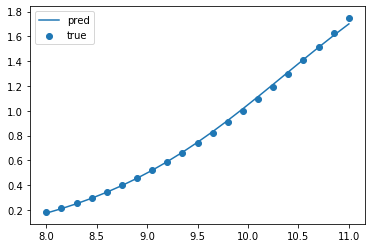

In [11]:
#test
plt.scatter(x_train0.detach().numpy(), y_train0.detach().numpy(), label='true')
plt.plot(x_train0.detach().numpy(), y_pred.detach().numpy(), label='pred')

plt.legend()
plt.show()